In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
'/content/drive/MyDrive/income_dataset.xlsx'

'/content/drive/MyDrive/income_dataset.xlsx'

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression

In [5]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 150)
PATH = "/content/drive/MyDrive/income_dataset.xlsx"   # <-- AJUSTA
df = pd.read_excel(PATH)

In [6]:
print(df.shape)
df.head()


(10000, 14)


,Age,Education_Level,Occupation,Number_of_Dependents,Location,Work_Experience,Marital_Status,Employment_Status,Household_Size,Homeownership_Status,Type_of_Housing,Gender,Primary_Mode_of_Transportation,Income
0,56,Master's,Technology,5,Urban,21,Married,Full-time,7,Own,Apartment,Male,Public transit,72510
1,69,High School,Finance,0,Urban,4,Single,Full-time,7,Own,Apartment,Male,Biking,75462
2,46,Bachelor's,Technology,1,Urban,1,Single,Full-time,7,Own,Single-family home,Female,Car,71748
3,32,High School,Others,2,Urban,32,Married,Full-time,1,Own,Apartment,Female,Car,74520
4,60,Bachelor's,Finance,3,Urban,15,Married,Self-employed,4,Own,Townhouse,Male,Walking,640210


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age                             10000 non-null  int64 
 1   Education_Level                 10000 non-null  object
 2   Occupation                      10000 non-null  object
 3   Number_of_Dependents            10000 non-null  int64 
 4   Location                        10000 non-null  object
 5   Work_Experience                 10000 non-null  int64 
 6   Marital_Status                  10000 non-null  object
 7   Employment_Status               10000 non-null  object
 8   Household_Size                  10000 non-null  int64 
 9   Homeownership_Status            10000 non-null  object
 10  Type_of_Housing                 10000 non-null  object
 11  Gender                          10000 non-null  object
 12  Primary_Mode_of_Transportation  10000 non-null 

### Separar numéricas vs categóricas










In [8]:
num_cols = df.select_dtypes(include="number").columns.tolist()
cat_cols = df.select_dtypes(include=["object","category","bool"]).columns.tolist()

print("N columnas numéricas:", len(num_cols))
print("N columnas categóricas:", len(cat_cols))
print("\nEjemplo numéricas:", num_cols[:10])
print("Ejemplo categóricas:", cat_cols[:10])

N columnas numéricas: 5
N columnas categóricas: 9

Ejemplo numéricas: ['Age', 'Number_of_Dependents', 'Work_Experience', 'Household_Size', 'Income']
Ejemplo categóricas: ['Education_Level', 'Occupation', 'Location', 'Marital_Status', 'Employment_Status', 'Homeownership_Status', 'Type_of_Housing', 'Gender', 'Primary_Mode_of_Transportation']


 Análisis por separado de numéricas vs categóricas






In [9]:
desc_num = df[num_cols].describe().T
card_cat = df[cat_cols].nunique(dropna=False).sort_values(ascending=False).to_frame("n_unique")

In [10]:
desc_num

,count,mean,std,min,25%,50%,75%,max
Age,10000.0,44.0217,1.520400e+01,18.0,31.0,44.0,57.0,70.0
Number_of_Dependents,10000.0,2.5270,1.713991e+00,0.0,1.0,3.0,4.0,5.0
Work_Experience,10000.0,24.8588,1.465262e+01,0.0,12.0,25.0,37.0,50.0
Household_Size,10000.0,3.9896,2.010496e+00,1.0,2.0,4.0,6.0,7.0
Income,10000.0,816838.1667,1.821089e+06,31044.0,68446.0,72943.0,350667.5,9992571.0


In [11]:
card_cat

,n_unique
Occupation,5
Education_Level,4
Primary_Mode_of_Transportation,4
Marital_Status,3
Location,3
Employment_Status,3
Type_of_Housing,3
Homeownership_Status,2
Gender,2


In [12]:
desc_num.to_excel("desc_num.xlsx")
card_cat.to_excel("card_cat.xlsx")

Quantiles (colas y outliers)


In [13]:
quantiles_num = (
    df[num_cols]
    .quantile([0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99])
    .T
)

quantiles_num


,0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99
Age,18.00,20.0,23.0,31.0,44.0,57.0,65.0,68.00,70.00
Number_of_Dependents,0.00,0.0,0.0,1.0,3.0,4.0,5.0,5.00,5.00
Work_Experience,0.00,2.0,4.0,12.0,25.0,37.0,45.0,48.00,50.00
Household_Size,1.00,1.0,1.0,2.0,4.0,6.0,7.0,7.00,7.00
Income,36121.95,64149.7,65766.0,68446.0,72943.0,350667.5,2890510.4,5343905.45,8836918.82


Diagnóstico de calidad de datos



In [14]:
n_duplicates = df.duplicated().sum()
print("Duplicados:", n_duplicates)


Duplicados: 0


In [15]:
df[num_cols].info()

# Missing real
df[num_cols].isna().mean().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Age                   10000 non-null  int64
 1   Number_of_Dependents  10000 non-null  int64
 2   Work_Experience       10000 non-null  int64
 3   Household_Size        10000 non-null  int64
 4   Income                10000 non-null  int64
dtypes: int64(5)
memory usage: 390.8 KB


,0
Age,0.0
Number_of_Dependents,0.0
Work_Experience,0.0
Household_Size,0.0
Income,0.0


In [16]:
df[cat_cols].isna().mean().sort_values(ascending=False)

,0
Education_Level,0.0
Occupation,0.0
Location,0.0
Marital_Status,0.0
Employment_Status,0.0
Homeownership_Status,0.0
Type_of_Housing,0.0
Gender,0.0
Primary_Mode_of_Transportation,0.0


5 valores más frecuentes (numéricas)





In [17]:
top5_num = {}
for col in num_cols[:10]:
    top5_num[col] = df[col].value_counts(dropna=False).head(5)

top5_num

{'Age': Age
 43    223
 66    216
 62    215
 40    212
 64    209
 Name: count, dtype: int64,
 'Number_of_Dependents': Number_of_Dependents
 5    1745
 3    1712
 1    1651
 0    1642
 4    1629
 Name: count, dtype: int64,
 'Work_Experience': Work_Experience
 2     224
 44    221
 48    219
 24    218
 33    216
 Name: count, dtype: int64,
 'Household_Size': Household_Size
 1    1477
 3    1445
 6    1437
 7    1433
 5    1411
 Name: count, dtype: int64,
 'Income': Income
 74306    10
 71180     7
 72296     6
 68116     6
 74294     6
 Name: count, dtype: int64}

5 valores más frecuentes (categóricas)



In [18]:
for col in cat_cols[:5]:
    print(f"\n--- {col} ---")
    display(df[col].value_counts(dropna=False).head(5))
    display(df[col].value_counts(normalize=True, dropna=False).head(5))


--- Education_Level ---


,count
Education_Level,
Bachelor's,4058
High School,2959
Master's,2482
Doctorate,501


,proportion
Education_Level,
Bachelor's,0.4058
High School,0.2959
Master's,0.2482
Doctorate,0.0501



--- Occupation ---


,count
Occupation,
Healthcare,3035
Technology,2407
Finance,1525
Others,1521
Education,1512


,proportion
Occupation,
Healthcare,0.3035
Technology,0.2407
Finance,0.1525
Others,0.1521
Education,0.1512



--- Location ---


,count
Location,
Urban,7037
Suburban,1951
Rural,1012


,proportion
Location,
Urban,0.7037
Suburban,0.1951
Rural,0.1012



--- Marital_Status ---


,count
Marital_Status,
Married,5136
Single,3900
Divorced,964


,proportion
Marital_Status,
Married,0.5136
Single,0.3900
Divorced,0.0964



--- Employment_Status ---


,count
Employment_Status,
Full-time,5004
Part-time,3016
Self-employed,1980


,proportion
Employment_Status,
Full-time,0.5004
Part-time,0.3016
Self-employed,0.1980


In [19]:
with pd.ExcelWriter("frecuencias_categoricas.xlsx") as writer:
    for col in cat_cols[:10]:
        vc_abs = df[col].value_counts(dropna=False).head(5)
        vc_rel = df[col].value_counts(normalize=True, dropna=False).head(5)

        out = pd.DataFrame({
            "conteo": vc_abs,
            "proporcion": vc_rel
        })

        out.to_excel(writer, sheet_name=col[:31])


Outliers


In [20]:
outlier_table = pd.DataFrame({
    "min": df[num_cols].min(),
    "p1": df[num_cols].quantile(0.01),
    "p50": df[num_cols].quantile(0.50),
    "p99": df[num_cols].quantile(0.99),
    "max": df[num_cols].max(),
}).sort_values("p99", ascending=False)

outlier_table.head(30)

,min,p1,p50,p99,max
Income,31044,36121.95,72943.0,8836918.82,9992571
Age,18,18.00,44.0,70.00,70
Work_Experience,0,0.00,25.0,50.00,50
Household_Size,1,1.00,4.0,7.00,7
Number_of_Dependents,0,0.00,3.0,5.00,5


Preprocesamiento


In [21]:
## no se encontararoon valores duplicados anteriormente
df[cat_cols] = df[cat_cols].apply(
    lambda s: s.astype(str).str.strip().replace({"?": np.nan, "": np.nan})
)

Análisis Exploratorio (EDA univariado) y Visualización

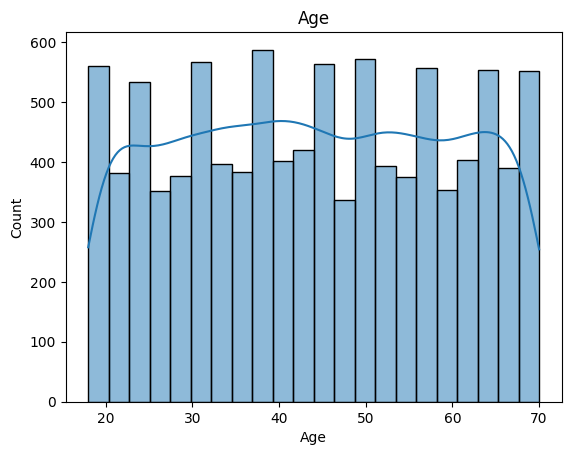

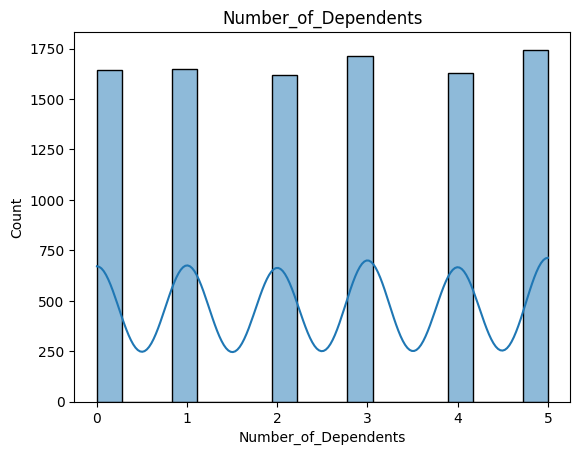

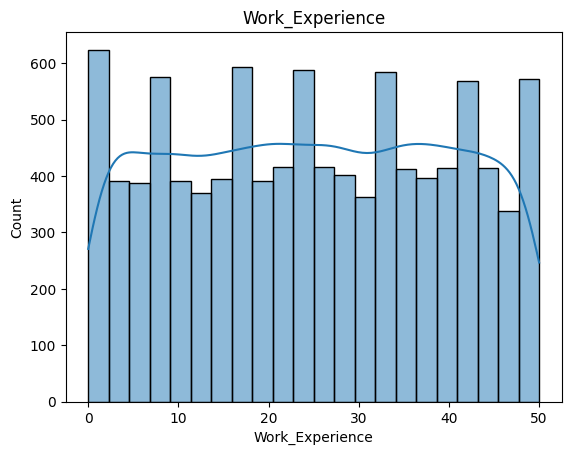

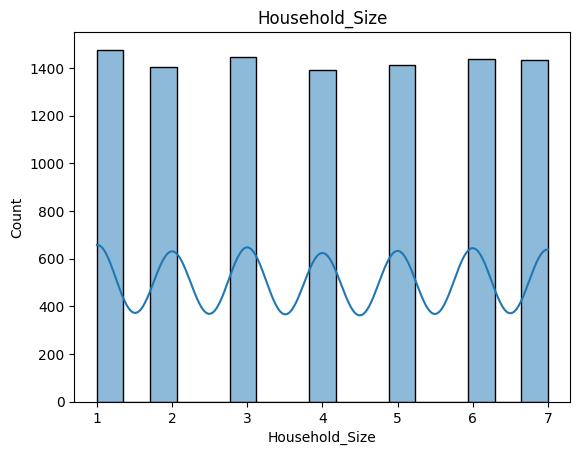

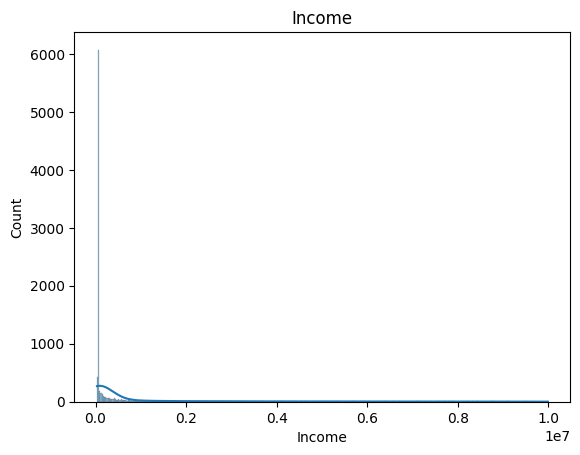

In [22]:

for col in num_cols[:5]:  # limitar para no saturar
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.show()

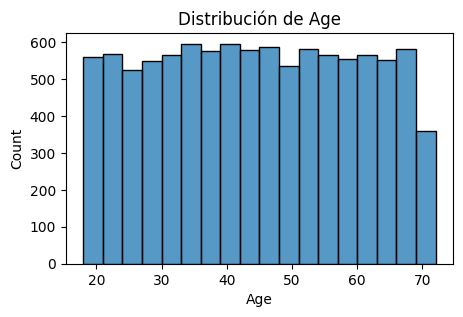

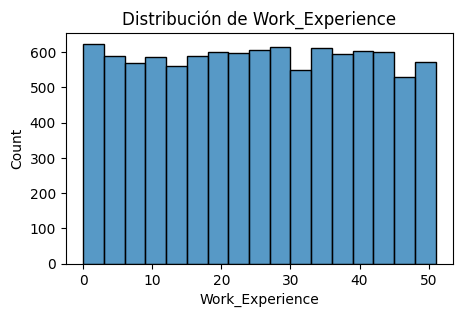

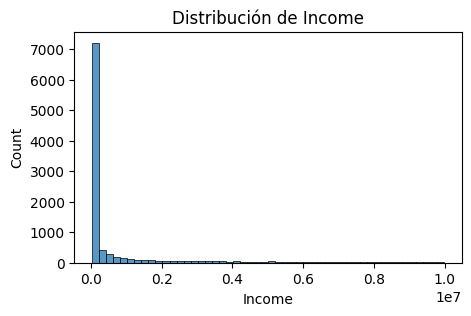

In [23]:
for col in ["Age", "Work_Experience", "Income"]:
    data = df[col].dropna()

    plt.figure(figsize=(5, 3))

    if col == "Income":
        sns.histplot(data, bins=50)
    else:
        min_v = int(data.min())
        max_v = int(data.max())
        bins = np.arange(min_v, max_v + 4, 3)
        sns.histplot(data, bins=bins)

    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.show()


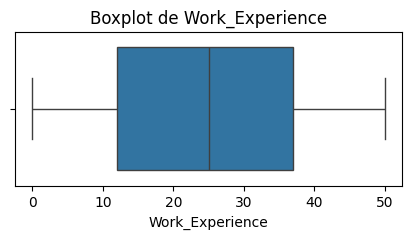

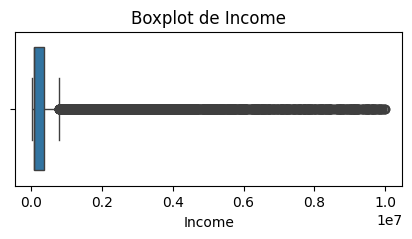

In [24]:
for col in ["Work_Experience", "Income"]:
    plt.figure(figsize=(5,2))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

    ## el Boxplot de experiencia laboral indica que la mayoria de los individuos se acumulan entre los 25 años como media. No hay valores atipicos
    ## para el caso de income

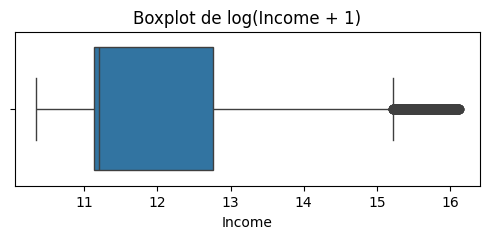

In [25]:
## se procedio a usar logaritmos para que la caja tenga mayor
## visualizacion y los outliers sean visibles a diferencia del anterior grafico

plt.figure(figsize=(6,2))
sns.boxplot(x=np.log1p(df["Income"]))
plt.title("Boxplot de log(Income + 1)")
plt.show()

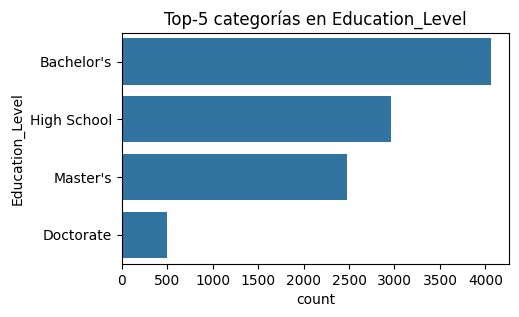

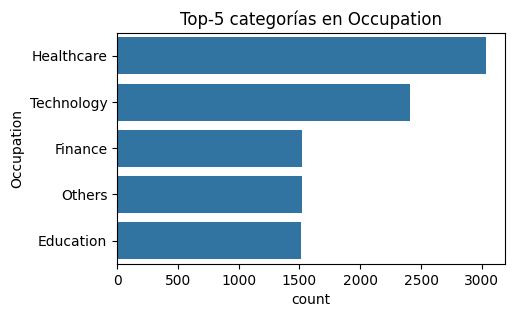

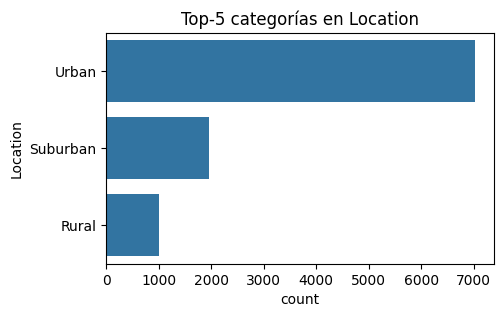

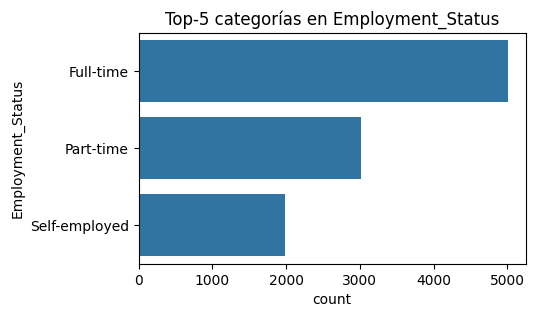

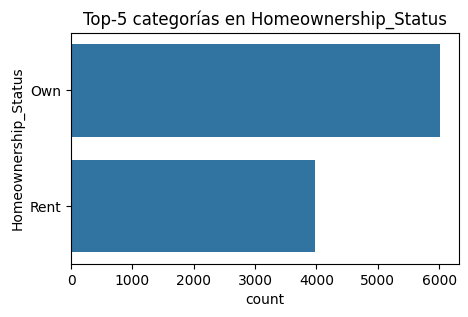

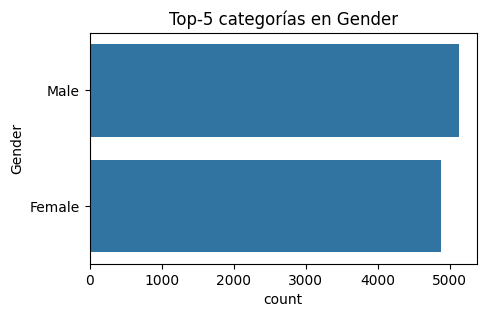

In [27]:
cat_example = ["Education_Level", "Occupation", "Location","Employment_Status","Homeownership_Status","Gender"]     ## solo se muestran 4 categorías

for col in cat_example:
    plt.figure(figsize=(5,3))
    top = df[col].value_counts().head(5).index
    sns.countplot(y=df[col], order=top)
    plt.title(f"Top-5 categorías en {col}")
    plt.show()

: